В этом уроке мы детально изучим слои нормализации.

 

Самая популярная версия слоя нормализации - слой нормализации "по батчу" (batch-norm слой).

Рассмотрим его работу в наиболее простом случае, когда на вход подается батч из одномерных векторов:

    На вход подается батч одномерных векторов:


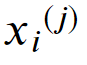

где j индекс вектора внутри батча, i - номер компоненты.

Для текущего батча:

    По каждой компоненте входа вычисляются мат.ожидание и дисперсия:

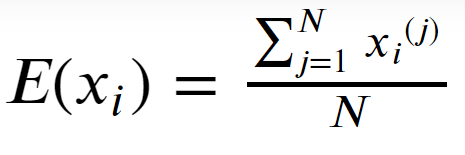
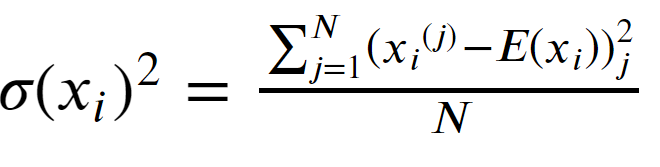

    Вход нормируется по формуле: 
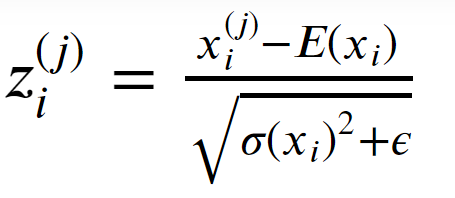

Эпсилон необходим для случая нулевой дисперсии.

    Нормированный вход преобразуется следующим образом:

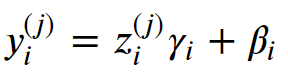

Где Гамма и Бета - обучаемые параметры слоя. Обратите внимание, Гамма и Бета - вектора такой же длины, как инстансы входа.

Их можно фиксировать, например, простейший случай - Бета принимается равным нулевому вектору, Гамма - вектору из единиц. 

Если же взять Гамму равным знаменателю дроби из формулы для Z, а Бету равным мат.ожиданию, то слой вернет входной тензор без изменений. То есть, слой будет эквивалентен тождественной функции.

 

Таким образом, параметры Бета и Гамма позволяют не терять входящию в слой информацию, и одновременно с этим, батч-норм слой нормализует вход. Последнее ускоряет сходимость параметров сети, а в некоторых случаях без нормализации добиться сходимости сети крайне сложно.

 

Итоговая формула преобразования входа: 

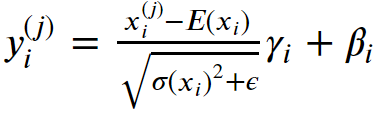

В этом уроке мы будем двигаться по следующему плану:

    Вначале реализуем train-этап батч-нормализации для батча из одномерных векторов с нулевым Бета и единичным Гамма.
    Затем добавим возможность задания параметров Бета и Гамма.
    После этого добавим eval-этап использования слоя.
    И последним шагом по батч-нормализации реализуем train-этап слоя батч-нормализации для батча из многоканальных двумерных тензоров с нулевым Бета и единичным Гамма.

После батч-нормализации вас ждут шаги по другим видам нормализации.

В данном шаге вам требуется реализовать функцию батч-нормализации без использования [стандартной функции](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d) со следующими упрощениями:

    Параметр Бета принимается равным 0.
    Параметр Гамма принимается равным 1.
    Функция должна корректно работать только на этапе обучения.
    Вход имеет размерность число элементов в батче * длина каждого инстанса.

 

Очень внимательно посмотрите на определение [функции](https://pytorch.org/docs/stable/generated/torch.std.html#torch.std), вычисляющей std.

In [15]:
import numpy as np
import torch
import torch.nn as nn


def custom_batch_norm1d(input_tensor, eps):
    '''Напишите в этом месте нормирование входного тензора'''
    
    # mean = torch.mean(input_tensor, dim=0)
    # var = torch.var(input_tensor, dim=0, unbiased=False)
    # sqrt = torch.sqrt(var + eps)
    # normed_tensor = (input_tensor - mean)/sqrt

    normed_tensor = ((input_tensor - input_tensor.mean(dim=0)) / 
                     torch.sqrt(input_tensor.var(dim=0, unbiased=False) + eps))
    
    return normed_tensor


input_tensor = torch.Tensor([[0.0, 0, 1, 0, 2], [0, 1, 1, 0, 10]])
batch_norm = nn.BatchNorm1d(input_tensor.shape[1], affine=False)

# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
import numpy as np
all_correct = True
for eps_power in range(10):
    eps = np.power(10., -eps_power)
    batch_norm.eps = eps
    batch_norm_out = batch_norm(input_tensor)
    custom_batch_norm_out = custom_batch_norm1d(input_tensor, eps)

    all_correct &= torch.allclose(batch_norm_out, custom_batch_norm_out)
    all_correct &= batch_norm_out.shape == custom_batch_norm_out.shape
print(all_correct)

True


Немного обобщим функцию с предыдущего шага - добавим возможность задавать параметры Бета и Гамма.

На данном шаге вам требуется реализовать функцию батч-нормализации без использования стандартной функции со следующими упрощениями:

    Функция должна корректно работать только на этапе обучения.
    Вход имеет размерность число элементов в батче * длина каждого инстанса.

gamma = weight
betta = bias

In [16]:
import torch
import torch.nn as nn


input_size = 7
batch_size = 5
input_tensor = torch.randn(batch_size, input_size, dtype=torch.float)

eps = 1e-3

def custom_batch_norm1d(input_tensor, weight, bias, eps):
    '''Напишите в этом месте нормирование тензора.'''
    
    normed_tensor = ((input_tensor - input_tensor.mean(dim=0)) / 
                     torch.sqrt(input_tensor.var(dim=0, unbiased=False) + eps)) * weight + bias
    return normed_tensor

# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
batch_norm = nn.BatchNorm1d(input_size, eps=eps)
batch_norm.bias.data = torch.randn(input_size, dtype=torch.float)
batch_norm.weight.data = torch.randn(input_size, dtype=torch.float)
batch_norm_out = batch_norm(input_tensor)
custom_batch_norm_out = custom_batch_norm1d(input_tensor, batch_norm.weight.data, batch_norm.bias.data, eps)
print(torch.allclose(batch_norm_out, custom_batch_norm_out) \
      and batch_norm_out.shape == custom_batch_norm_out.shape)

True


Избавимся еще от одного упрощения - реализуем работу слоя батч-нормализации на этапе предсказания.

На этом этапе вместо статистик по батчу будем использовать экспоненциально сглаженные статистики из истории обучения слоя.

В данном шаге вам требуется реализовать полноценный класс батч-нормализации без использования стандартной функции, принимающий на вход двумерный тензор. Осторожно, расчёт дисперсии ведётся по смещенной выборке, а расчет скользящего среднего по несмещенной.

In [ ]:
import torch
import torch.nn as nn


input_size = 3
batch_size = 5
eps = 1e-1


class CustomBatchNorm1d:
    def __init__(self, weight, bias, eps, momentum):
        # конструктор
        self.weight = weight
        self.bias = bias
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.ema_mn = 0                                           # Скользящая стредняя средних значений
        self.ema_var = 1                                          # Скользащяя средняя дисперсии

        
    def __call__(self, input_tensor):
        # нормирование входного тензора.
        mn = torch.mean(input_tensor, 0)                           # Среднее значение батча
        var = torch.var(input_tensor, 0, unbiased=False)           # Дисперсия по батчу (var = std**2)
        m = input_tensor.size(0)                                   # Количество значений (размер батча)
        
        if self.training:
            # Если модель тренируется, то применяем средние значения по батчу
            self.ema_mn = (1 - self.momentum) * self.ema_mn + self.momentum * mn
            self.ema_var = (1 - self.momentum) * var * (m / (m - 1)) + self.momentum * self.ema_var
        else:
            # Если модель в режиме предсказания, то применяем накопленные скользящии среднии
            mn = self.ema_mn
            var = self.ema_var

        # Выполняем нормировку тензора
        normed_tensor = (input_tensor - mn) / (var + self.eps)**(1/2) * self.weight + self.bias
        return normed_tensor

    
    def eval(self):
        # В этом методе реализуйте переключение в режим предикта.
        self.training = False


batch_norm = nn.BatchNorm1d(input_size, eps=eps)
batch_norm.bias.data = torch.randn(input_size, dtype=torch.float)
batch_norm.weight.data = torch.randn(input_size, dtype=torch.float)
batch_norm.momentum = 0.5

custom_batch_norm1d = CustomBatchNorm1d(batch_norm.weight.data,
                                        batch_norm.bias.data, eps, batch_norm.momentum)


# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
# all_correct = True

# for i in range(8):
#     torch_input = torch.randn(batch_size, input_size, dtype=torch.float)
#     norm_output = batch_norm(torch_input)
#     custom_output = custom_batch_norm1d(torch_input)
#     all_correct &= torch.allclose(norm_output, custom_output) \
#         and norm_output.shape == custom_output.shape

# batch_norm.eval()
# custom_batch_norm1d.eval()

# for i in range(8):
#     torch_input = torch.randn(batch_size, input_size, dtype=torch.float)
#     norm_output = batch_norm(torch_input)
#     custom_output = custom_batch_norm1d(torch_input)
#     all_correct &= torch.allclose(norm_output, custom_output) \
#         and norm_output.shape == custom_output.shape
# print(all_correct)

Как вы могли убедиться, реализовать батч-норм слой на этапе предсказания не так просто, поэтому в дальнейших шагах этого урока мы больше не будем требовать реализовать эту часть.

 

Слой батч-нормализации существует для входа любой размерности.

В данном шаге рассмотрим его для входа из многоканальных двумерных тензоров, например, изображений.

Если вытянуть каждый канал картинки в вектор, то вход будет трехмерным:

    количество картинок в батче
    число каналов в каждой картинке
    число пикселей в картинке
    
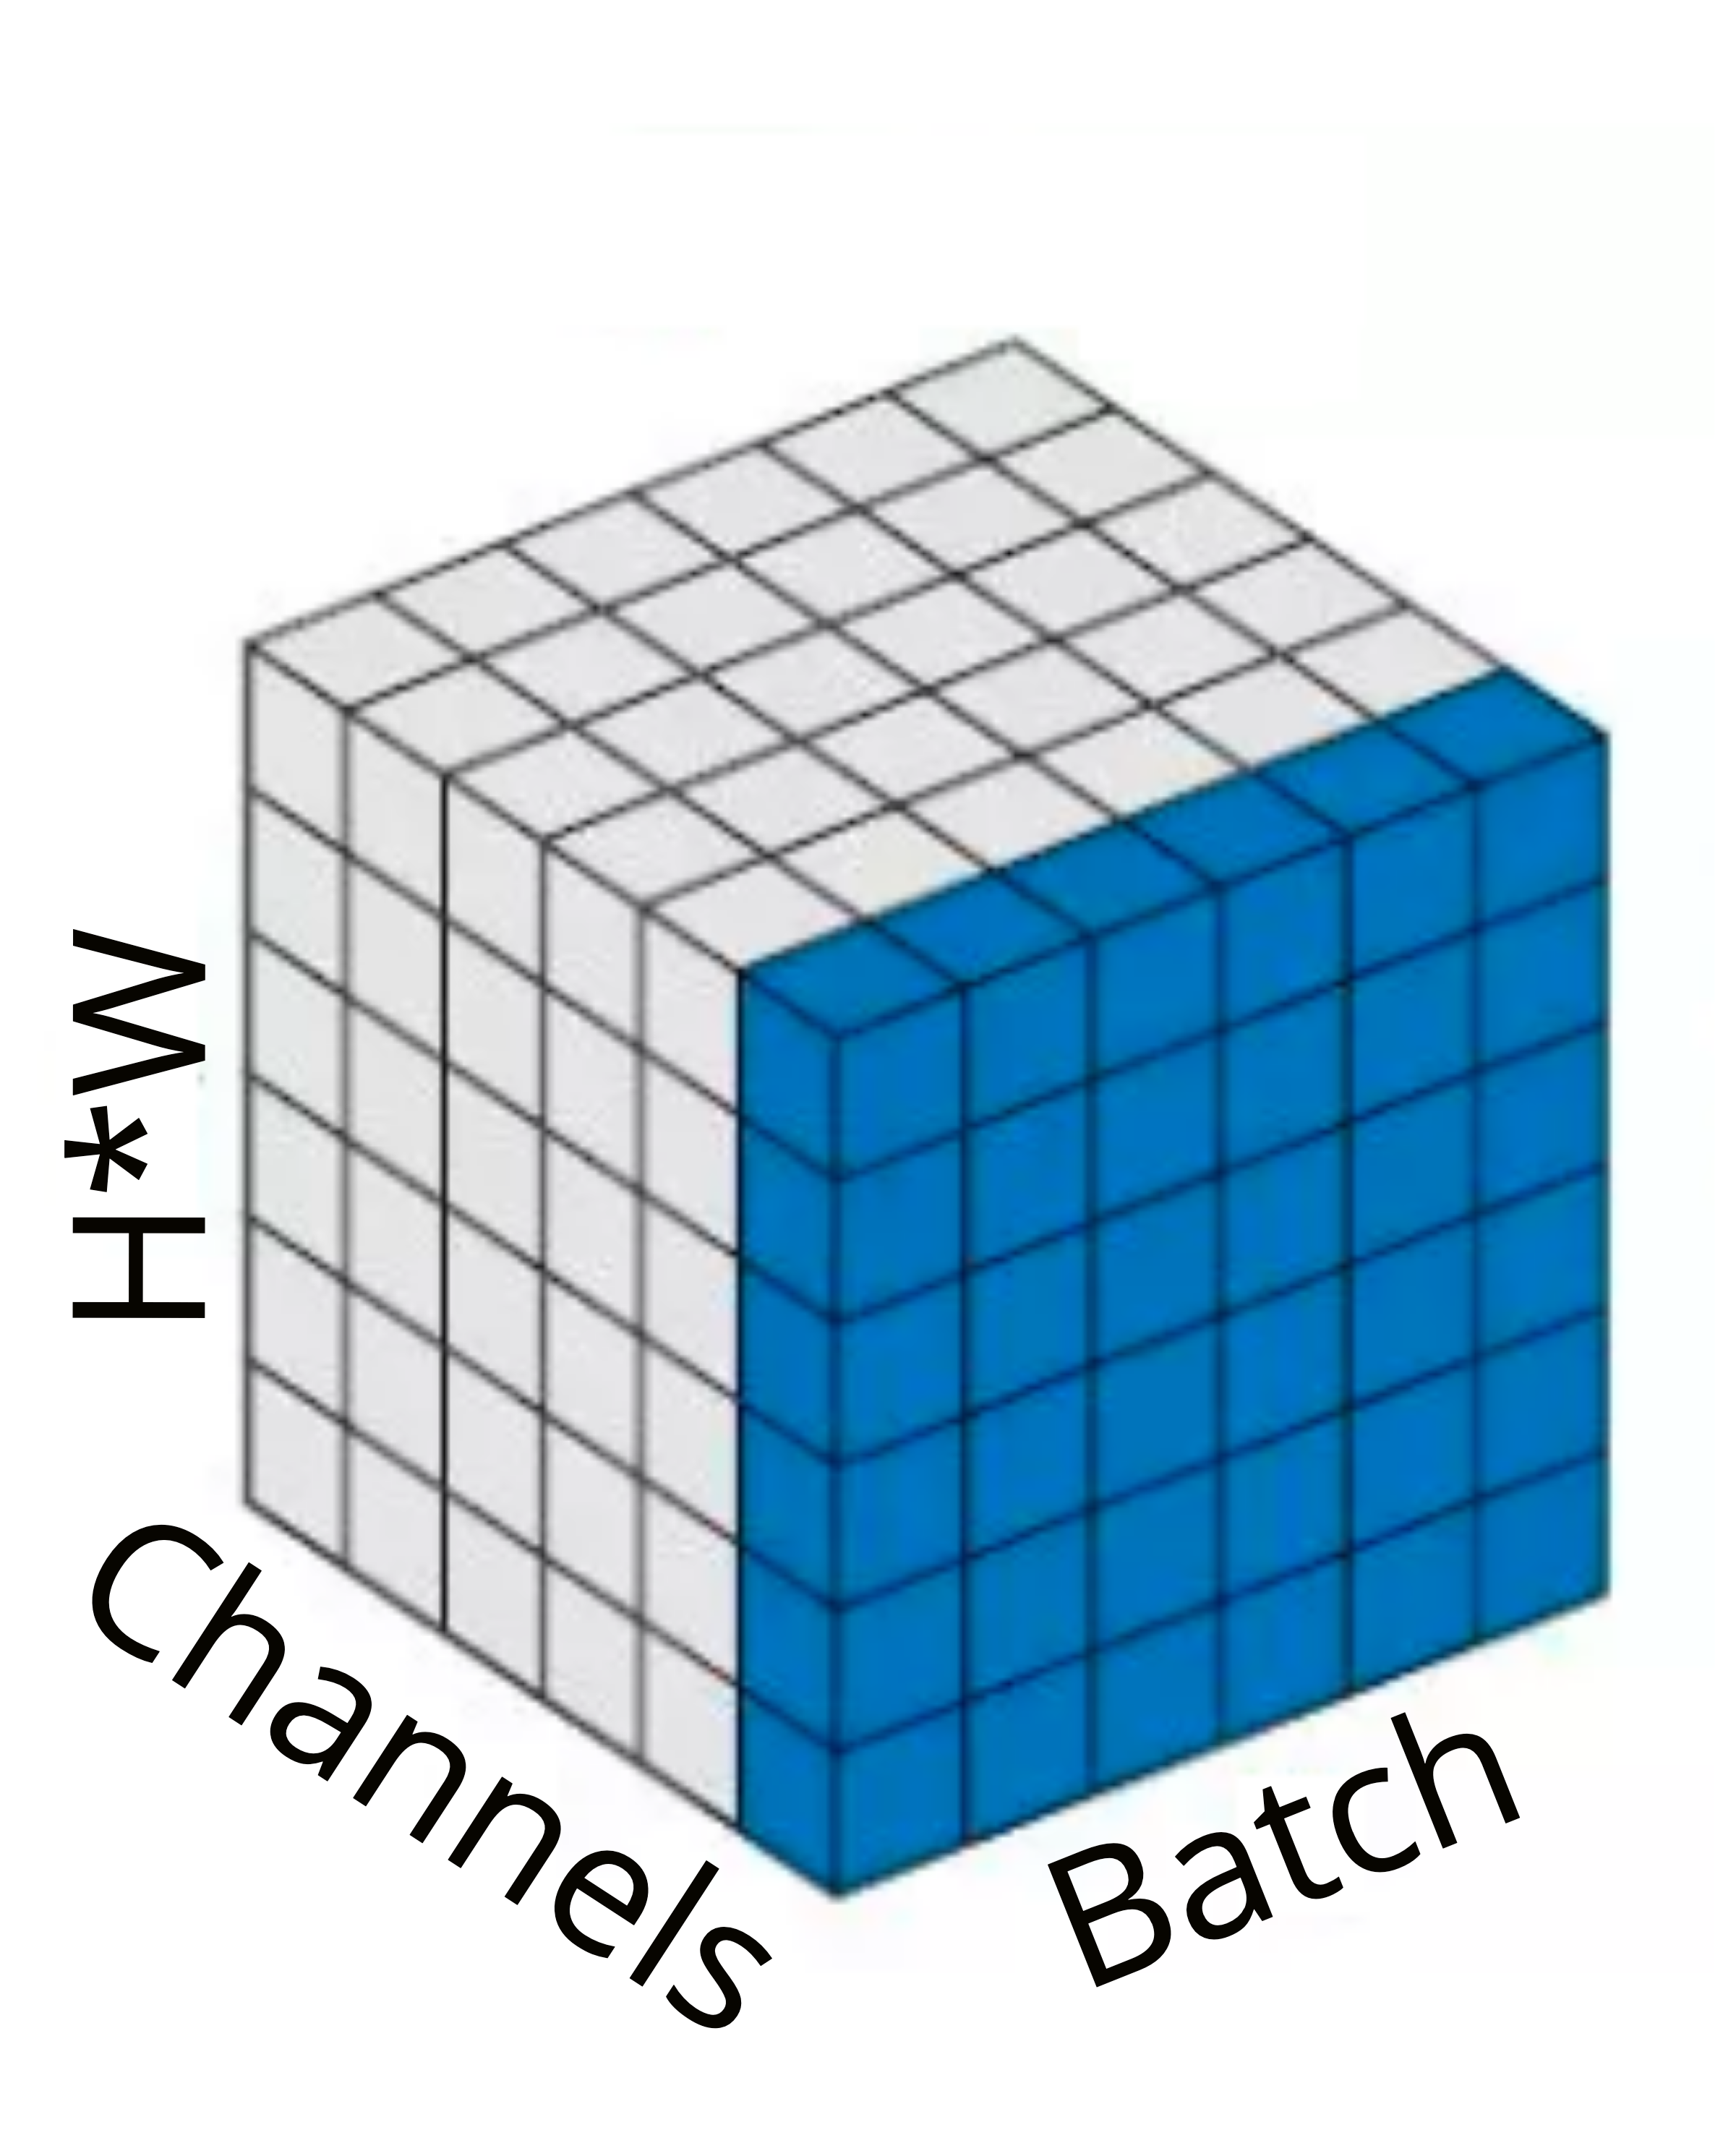

Процесс нормализации:

    Вход разбивается на срезы, параллельные синей части. То есть, каждый срез - это все пиксели всех изображений по одному из каналов.
    Для каждого среза считаются мат. ожидание и дисперсия.
    Каждый срез нормализуется независимо.

 

На данном шаге вам предлагается реализовать батч-норм слой для четырехмерного входа (например, батч из многоканальных двумерных картинок) без использования [стандартной реализации](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d) со следующими упрощениями:

    Параметр Бета = 0.
    Параметр Гамма = 1.
    Функция должна корректно работать только на этапе обучения.


In [28]:
import torch
import torch.nn as nn

eps = 1e-3

input_channels = 3
batch_size = 3
height = 10
width = 10

batch_norm_2d = nn.BatchNorm2d(input_channels, affine=False, eps=eps)

input_tensor = torch.randn(batch_size, input_channels, height, width, dtype=torch.float)


def custom_batch_norm2d(input_tensor, eps):
    '''нормирование тензора'''
    
    mn = input_tensor.mean([0, 2, 3])
    var = input_tensor.var([0, 2, 3], unbiased=False)
    # в старых версиях торч делаем так 
    # var = torch.cat([torch.var(input_tensor[:,c,:,:], unbiased=False).unsqueeze(0) for c in range(input_tensor.shape[1])], dim=0)
    normed_tensor =  (input_tensor - mn[None, :, None, None]) / (torch.sqrt(var[None, :, None, None] + eps))
        
    return normed_tensor



# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
norm_output = batch_norm_2d(input_tensor)
custom_output = custom_batch_norm2d(input_tensor, eps)
print(torch.allclose(norm_output, custom_output) and norm_output.shape == custom_output.shape)

True


In [ ]:
# Т.к. в данном случае var не работает с несколькими осями, просто вспоминаем, как этот var можно получить из mean

def custom_batch_norm2d(input_tensor, eps):
    # метод нормирование тензора.
    mean = input_tensor.mean(dim=(0,2,3), keepdim=True)
    var = (input_tensor - mean).pow(2).mean(dim=(0,2,3), keepdim=True)
    normed_tensor = (input_tensor - mean)/torch.sqrt(var+eps)
    return normed_tensor

Одно из самых простых решений:
функция torch.mean (или метод torch.Tensor.mean) в качестве параметра dim может принимать как одну ось (вдоль которой надо посчитать среднее), так и кортеж (tuple) из этих осей, чем мы и пользуемся, считая среднее вдоль осей B, H, W. Получаем вектор из C чисел, а потом преобразовываем его в тензор размерности (1, C, 1, 1). То есть просто вставляем единички в те измерения, по которым мы считали среднее. Теперь у нас PyTorchне будет ругаться на размерности тензоров в арифметических операциях.

К сожалению в той версии PyTorch, которая используется для проверки решений, аналогичный параметр dim в функции torch.var (или в методе torch.Tensor.var) принимает ТОЛЬКО одно число (в новых версиях он уже умеет принимать кортеж чисел). Поэтому мы пройдемся в цикле по всем каналам и посчитаем по каждому из них дисперсию, а потом предпримем аналогичный шаг с решейпом, как и для среднего.

In [ ]:
def custom_batch_norm2d(input_tensor, eps):
    # считаем среднее вдоль осей 0, 2, 3 (batch, height, width), получаем вектор из C чисел,
    # а потом решейпим в размерность [1, C, 1, 1], чтобы арифметика работала
    mean = input_tensor.mean(dim=(0, 2, 3)).view(1, -1, 1, 1)
    
    # старая версия PyTorch не умеет считать дисперсию по нескольким осям
    # поэтому мы считаем ее ручками
    vars = [input_tensor[:, c, ...].var(unbiased=False) for c in range(input_channels)]
    var = torch.tensor(vars).view(1, -1, 1, 1)
    normed_tensor = (input_tensor - mean) / torch.sqrt(var + eps)
    
    return normed_tensor

Мы познакомились поближе с нормализацией "по батчу". Для упрощения дальнейшего изложения остановимся на случае трехмерного тензора на входе слоя, если же размерность входа больше трех, то вытянем все размерности кроме первых двух в одну размерность.

Бывает нормировка не только по батчу, но и по другим измерениям.

Обратите внимание на изображения ниже.

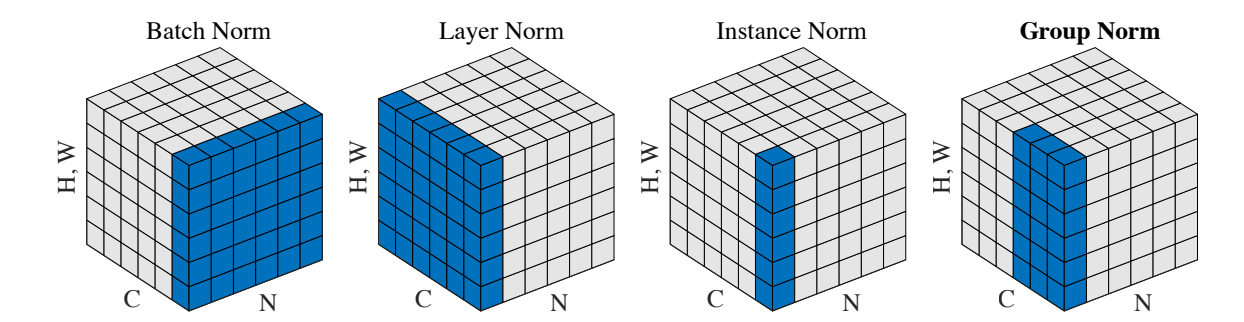

Где:

    C - число каналов на входе.
    N - размер батча.
    H, W - размерность по последней (третьей) размерности входа.

 

На изображении можно увидеть следующие виды нормализации:

    По батчу.
    По каналу.
    По инстансу.
    По группе.

Кроме указанных видов, также существует множество других, выходящих за рамки нашего урока.

Указанные виды нормализации мы рассмотрим в дальнейших шагах.

https://nn.labml.ai/normalization/index.html

Идея, лежащая в основе слоя нормализации "по каналу", что сеть должна быть независимой от контраста исходного изображения.

Нормализация "по каналу" работает независимо по каждому изображению батча.

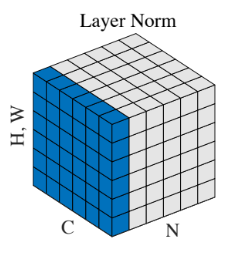

На этом шаге вам предлагается реализовать нормализацию "по каналу" без использования стандартного слоя со следующими упрощениями:

    Параметр Бета = 0.
    Параметр Гамма = 1.
    Требуется реализация только этапа обучения.
    Нормализация делается по всем размерностям входа, кроме нулевой.

Обратите внимание, что размерность входа на данном шаге не фиксирована.

Уточним, что в слое нормализации "по каналу" статистики считаются по всем размерностям, кроме нулевой.

In [53]:
import torch
import torch.nn as nn


eps = 1e-10


def custom_layer_norm(input_tensor, eps):
    '''нормирование тензора'''
    
    normed_tens = torch.zeros(input_tensor.shape)
    for i in range (input_tensor.shape[0]):
        mean = torch.tensor(input_tensor[i].numpy().mean())
        var = torch.tensor(input_tensor[i].numpy().var())
        normed_tens[i] += (input_tensor[i] - mean) / torch.sqrt(var + eps)
    return normed_tens


# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
all_correct = True
for dim_count in range(3, 9):
    input_tensor = torch.randn(*list(range(3, dim_count + 2)), dtype=torch.float)
    layer_norm = nn.LayerNorm(input_tensor.size()[1:], elementwise_affine=False, eps=eps)

    norm_output = layer_norm(input_tensor)
    custom_output = custom_layer_norm(input_tensor, eps)

    all_correct &= torch.allclose(norm_output, custom_output, 1e-2)
    all_correct &= norm_output.shape == custom_output.shape
print(all_correct)

True


In [ ]:
def custom_layer_norm(input_tensor, eps):
    # Напишите в этом методе нормирование тензора.
    dims = [i for i in range(len(input_tensor.size())) if i>0]
    mean = input_tensor.mean(dim=dims, keepdim=True)
    var = (input_tensor-mean).pow(2).mean(dim=dims, keepdim=True)
    normed_tensor = (input_tensor-mean)/torch.sqrt(var+eps)
    return normed_tensor

Нормализация "по инстансу" была изначально разработана для задачи style transfer. Идея, лежащая в основе этого слоя, что сеть должна быть независимой от контраста отдельных каналов исходного изображения.

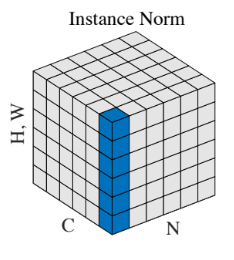

На этом шаге вам предлагается реализовать нормализацию "по инстансу" без использования стандартного слоя со следующими упрощениями:

    Параметр Бета = 0.
    Параметр Гамма = 1.
    На вход подается трехмерный тензор (размер батча, число каналов, длина каждого канала инстанса).
    Требуется реализация только этапа обучения.

В слое нормализации "по инстансу" статистики считаются по последней размерности (по каждому входному каналу каждого входного примера).

In [54]:
import torch
import torch.nn as nn


eps = 1e-3

batch_size = 5
input_channels = 2
input_length = 30

instance_norm = nn.InstanceNorm1d(input_channels, affine=False, eps=eps)

input_tensor = torch.randn(batch_size, input_channels, input_length, dtype=torch.float)


def custom_instance_norm1d(input_tensor, eps):
    '''нормирование тензора'''
    mean = input_tensor.mean(dim=2, keepdim=True)
    var = input_tensor.var(dim=2, unbiased=False, keepdim=True)
    return (input_tensor - mean) / torch.sqrt(var + eps)


# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
norm_output = instance_norm(input_tensor)
custom_output = custom_instance_norm1d(input_tensor, eps)
print(torch.allclose(norm_output, custom_output) and norm_output.shape == custom_output.shape)

True


Нормализация "по группе" - это обобщение нормализации "по каналу" и "по инстансу".

Каналы в изображении не являются полностью независимыми, поэтому возможность использования статистики соседних каналов является преимуществом нормализации "по группе" по сравнению с нормализацией "по инстансу".

В то же время, каналы изображения могут сильно отличатся, поэтому нормализация "по группе" является более гибкой, чем нормализация "по каналу".

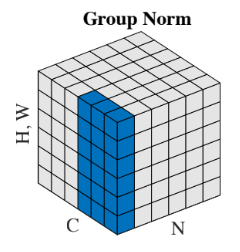

На этом шаге вам предлагается реализовать нормализацию "по группе" без использования стандартного слоя со следующими упрощениями:

    Параметр Бета = 0.
    Параметр Гамма = 1.
    Требуется реализация только этапа обучения.
    На вход подается трехмерный тензор.

Также слой принимает на вход число групп.

В слое нормализации "по группе" статистики считаются очень похоже на нормализацию "по каналу", только каналы разбиваются на группы.

In [56]:
import torch
import torch.nn as nn


channel_count = 6
eps = 1e-3
batch_size = 20
input_size = 2

input_tensor = torch.randn(batch_size, channel_count, input_size)


def custom_group_norm(input_tensor, groups, eps):
    '''нормирование тензора'''
    
    input_tensor_shape = input_tensor.shape
    batch_size = input_tensor_shape[0]
    input_tensor = input_tensor.view(batch_size, groups, -1)
    mean = input_tensor.mean(dim=[-1], keepdim=True)
    mean_x2 = (input_tensor ** 2).mean(dim=[-1], keepdim=True)
    var = mean_x2 - mean ** 2
    normed_tensor = (input_tensor - mean) / torch.sqrt(var + eps)
    
    return normed_tensor.view(input_tensor_shape)
    


# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
all_correct = True
for groups in [1, 2, 3, 6]:
    group_norm = nn.GroupNorm(groups, channel_count, eps=eps, affine=False)
    norm_output = group_norm(input_tensor)
    custom_output = custom_group_norm(input_tensor, groups, eps)
    all_correct &= torch.allclose(norm_output, custom_output, 1e-3)
    all_correct &= norm_output.shape == custom_output.shape

print(all_correct)

True


In [ ]:
# В первой строке объединяем каналы в группы и делаем их (группы) плоскими за одну операцию.

def custom_group_norm(X, groups, eps):
    # объединяем каналы в группы
    grouped = X.reshape(X.shape[0], groups, -1)
    mean = grouped.mean(dim=2, keepdim=True)
    var = grouped.var(dim=2, unbiased=False, keepdim=True)
    return ((grouped - mean) / torch.sqrt(var + eps)).reshape(*X.shape)

In [59]:
norm_output.reshape

TypeError: reshape() missing 1 required positional arguments: "shape"

In [58]:
norm_output.view

<function Tensor.view>